<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Capture-Picture-for-geometric-path-presentation" data-toc-modified-id="Capture-Picture-for-geometric-path-presentation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Capture Picture for geometric path presentation</a></span></li><li><span><a href="#Simulate-nominal-motion" data-toc-modified-id="Simulate-nominal-motion-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simulate nominal motion</a></span></li><li><span><a href="#Simulate-all-three-controller" data-toc-modified-id="Simulate-all-three-controller-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simulate all three controller</a></span><ul class="toc-item"><li><span><a href="#Preview-TT-controller" data-toc-modified-id="Preview-TT-controller-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Preview TT controller</a></span></li><li><span><a href="#Error-trajectory" data-toc-modified-id="Error-trajectory-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Error trajectory</a></span></li></ul></li></ul></div>

In [1]:
import sys
sys.path.append('../')
import following_lib as fo

In [2]:
import numpy as np
import openravepy as orpy
import toppra as ta
import matplotlib.pyplot as plt
from rave.Rave import inv_dyn
import time

# Setup Logging
import logging
import coloredlogs
logger = logging.getLogger('trajectory')
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler('traj.log', mode='a')
logger.addHandler(fh)

# Setup logging for toppra
coloredlogs.install(level='DEBUG')
np.set_printoptions(5)

# Load OpenRAVE environment
env = orpy.Environment()
env.SetViewer('qtosg')

True

# Capture Picture for geometric path presentation

This script generate and setup the robot to demonstrate a geometric path.

In [37]:
env.Reset()
# Load N robots
N = 3
for i in range(N):
    env.Load('/home/hung/git/robotic-CRI/rave/denso_vs060.dae')

# Geometric path
waypoints = np.array([[0., 0., 0., 0., 0., 0.],
                      [-1., 0.5, 0.5, 0., 0.5, 0.9],
                      [1., 0.8, 1.3, 0.4, 1., 1.2],
                      [1., 0.9, 1.7, 0.2, 0.5, 0.8]])
path = ta.SplineInterpolator(np.linspace(0, 1, 4), waypoints)

In [38]:
ss = [0, 0.35, 0.7]
q = path.eval(ss)
for i, q_ in enumerate(q):
    env.GetRobots()[i].SetDOFValues(q_)

for l in env.GetRobots()[1].GetLinks():
    for geom in l.GetGeometries():
        geom.SetTransparency(0.2)
        

for l in env.GetRobots()[2].GetLinks():
    for geom in l.GetGeometries():
        geom.SetTransparency(0.3)

In [39]:
viewer = env.GetViewer()
viewer.SetCamera(np.array([[-0.6423 ,  0.23435, -0.72975,  1.76622],
       [ 0.7662 ,  0.22085, -0.60346,  1.46306],
       [ 0.01975, -0.94674, -0.32141,  1.24293],
       [ 0.     ,  0.     ,  0.     ,  1.     ]]))

# Simulate nominal motion

In [40]:
env.Reset()
env.Load('/home/hung/git/robotic-CRI/rave/denso_vs060.dae')
robot = env.GetRobots()[0]

tau_max = np.r_[30., 70., 70., 30., 20., 20.] * 2
robot.SetDOFTorqueLimits(tau_max)
robot.SetDOFVelocityLimits(tau_max)
tau_min = - tau_max

# TOPP
N = 100
ss = np.linspace(0, 1, N+1)
cnst = ta.create_rave_torque_path_constraint(path, np.linspace(0, 1, N+1), robot)
cnst_intp = ta.interpolate_constraint(cnst)
pp = ta.qpOASESPPSolver([cnst_intp])
pp.set_goal_interval([0, 1e-8])
pp.set_start_interval([0, 1e-5])
pp.solve_controllable_sets()
us, xs = pp.solve_topp()
ts, qs, qds, qdds, ss_ref = fo.compute_trajectory_points(
    path, pp.ss, us, xs, dt=1e-3, smooth=False)



2018-02-28 20:35:15 hung-asus toppra.constraints[28224] INFO Torque bounds for OpenRAVE robot generated.
2018-02-28 20:35:15 hung-asus toppra.TOPP[28224] INFO 
Initialize Path Parameterization instance
------------------------------
	 N                  :      100
	 No. of constraints :        1
	 No. of slack var   :        0
	 No. of can. ineq.  :       24
	 No. of equalities  :        0
	 No. of inequalities:        0

2018-02-28 20:35:15 hung-asus toppra.TOPP[28224] DEBUG Set qpOASES print level to NONE


In [41]:
slowdown = 2
for q_ in qs:
    robot.SetDOFValues(q_)
    time.sleep(1e-3 * slowdown)

# Simulate all three controller

OSG is actually the TOPT controller

In [86]:
# Tracking parameter
lamb = 30

###############################################################################
#                   OSG_tb : Online Scaling w/Robust guarantee               #
###############################################################################

# Robust controllable sets the OSG controller
# TODO: Compute Ps propoerly.
vs = np.zeros((N+1, 12, 3))
Ps = np.zeros((N+1, 12, 3, 3))
vs[:, :, 0] = cnst.a
vs[:, :, 1] = cnst.b
vs[:, :, 2] = cnst.c

Ps[:, 0] = np.eye(3) * 50
Ps[:, 6] = np.eye(3) * 50
Ps[:, 1] = np.eye(3) * 50
Ps[:, 7] = np.eye(3) * 50
Ps[:, 2] = np.eye(3) * 50
Ps[:, 8] = np.eye(3) * 50
Ps[:, 3] = np.eye(3) * 50
Ps[:, 9] = np.eye(3) * 50
Ps[:, 4] = np.eye(3) * 50
Ps[:, 10] = np.eye(3)* 50
Ps[:, 5] = np.eye(3) * 50
Ps[:, 11] = np.eye(3)* 50


robust_cnst = fo.RobustPathConstraint(vs, Ps, ss)
ws = 0.13 * np.ones(N+1)  # Norm of the tracking error
Ks = np.ones((N+1, 2))  # Robust controllable sets
Ks[N] = [0, 1e-8]
for i in range(N-1, -1, -1):
    logger.info("OSRG: compute robust controllable set i={:d}".format(i))
    Ks[i] = fo.robust_one_step(robust_cnst, i, Ks[i + 1], ws[i], ws[i + 1], method='ECOS')


2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=99
2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=98
2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=97
2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=96
2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=95
2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=94
2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=93
2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=92
2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=91
2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=90
2018-02-28 20:43:41 hung-asus trajectory

2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=13
2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=12
2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=11
2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=10
2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=9
2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=8
2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=7
2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=6
2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=5
2018-02-28 20:43:41 hung-asus trajectory[28224] INFO OSRG: compute robust controllable set i=4
2018-02-28 20:43:41 hung-asus trajectory[28224

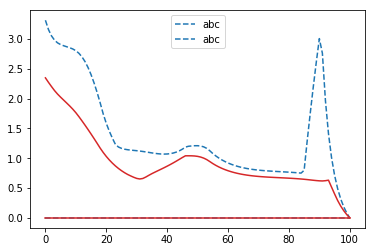

In [87]:

plt.plot(pp.K, '--', c='C0', label='abc')
plt.plot(Ks, c='C3')
# plt.plot(xs)
plt.legend()
plt.show()

In [88]:

# Define experiments
reload(fo)
OSG_exp = fo.ExperimentOSG(robot, path, Ks, ss,
                           tau_min, tau_max, lamb)
OS_exp = fo.ExperimentOS(robot, path, us, xs, ss,
                         tau_min, tau_max, lamb)
TT_exp = fo.ExperimentTT(robot, path, qs, qds, qdds,
                         tau_min, tau_max, lamb)
TT_notrb_exp = fo.ExperimentTT(robot, path, qs, qds, qdds,
                               10 * tau_min, 10 * tau_max, lamb)
experiments = [OSG_exp, OS_exp, TT_exp]

# Setup
initial_err = np.array([0, -0.05122,  - 0.02318,
                        - 0.09367 , -0.0,  0.,
                        0.      ,  0.     ,  0.     ,
                        0.      ,  0.     ,  0.     ])
initial_err = 0.25 * initial_err / np.linalg.norm(initial_err)

noise_det_sampled = np.random.randn(10000, 6)
def noise_function(t, noise_det_sampled=noise_det_sampled):
    return np.diag([0.3, 0.8, 0.2, 0.1, 0.2, 0.1]).dot(
        noise_det_sampled[int(t / 1e-3)])

for exp in experiments:
    exp.set_unit_noise_function(noise_function)
    # exp.set_noise_level(10.)
    exp.set_noise_level(0.)
    exp.set_initial_error(initial_err)
    exp.lamb = lamb
    exp.reset()

TT_res = TT_exp.run()
OSG_res = OSG_exp.run()
OS_res = OS_exp.run()


2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Starting simulation
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 0.000000%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 0.086133%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 0.172265%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 0.258398%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 0.344531%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 0.430663%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 0.516796%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 0.602929%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 0.689061%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 0.775194%
2018-02-28 20:43:42 hung-asus following_lib[28224] DE

2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 8.096469%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 8.182601%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 8.268734%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 8.354866%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 8.440999%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 8.527132%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 8.613264%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 8.699397%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 8.785530%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 8.871662%
2018-02-28 20:43:42 hung-asus following_lib[28224] DEBUG Simulation progress 8.957795%
2018-02-28 20:43:42 hung-asus following_lib

2018-02-28 20:43:43 hung-asus following_lib[28224] DEBUG Simulation progress 16.192937%
2018-02-28 20:43:43 hung-asus following_lib[28224] DEBUG Simulation progress 16.279070%
2018-02-28 20:43:43 hung-asus following_lib[28224] DEBUG Simulation progress 16.365202%
2018-02-28 20:43:43 hung-asus following_lib[28224] DEBUG Simulation progress 16.451335%
2018-02-28 20:43:43 hung-asus following_lib[28224] DEBUG Simulation progress 16.537468%
2018-02-28 20:43:43 hung-asus following_lib[28224] DEBUG Simulation progress 16.623600%
2018-02-28 20:43:43 hung-asus following_lib[28224] DEBUG Simulation progress 16.709733%
2018-02-28 20:43:43 hung-asus following_lib[28224] DEBUG Simulation progress 16.795866%
2018-02-28 20:43:43 hung-asus following_lib[28224] DEBUG Simulation progress 16.881998%
2018-02-28 20:43:43 hung-asus following_lib[28224] DEBUG Simulation progress 16.968131%
2018-02-28 20:43:43 hung-asus following_lib[28224] DEBUG Simulation progress 17.054264%
2018-02-28 20:43:43 hung-asus fo

2018-02-28 20:43:44 hung-asus following_lib[28224] DEBUG Simulation progress 24.289406%
2018-02-28 20:43:44 hung-asus following_lib[28224] DEBUG Simulation progress 24.375538%
2018-02-28 20:43:44 hung-asus following_lib[28224] DEBUG Simulation progress 24.461671%
2018-02-28 20:43:44 hung-asus following_lib[28224] DEBUG Simulation progress 24.547804%
2018-02-28 20:43:44 hung-asus following_lib[28224] DEBUG Simulation progress 24.633936%
2018-02-28 20:43:44 hung-asus following_lib[28224] DEBUG Simulation progress 24.720069%
2018-02-28 20:43:44 hung-asus following_lib[28224] DEBUG Simulation progress 24.806202%
2018-02-28 20:43:44 hung-asus following_lib[28224] DEBUG Simulation progress 24.892334%
2018-02-28 20:43:44 hung-asus following_lib[28224] DEBUG Simulation progress 24.978467%
2018-02-28 20:43:44 hung-asus following_lib[28224] DEBUG Simulation progress 25.064599%
2018-02-28 20:43:44 hung-asus following_lib[28224] DEBUG Simulation progress 25.150732%
2018-02-28 20:43:44 hung-asus fo

2018-02-28 20:43:45 hung-asus following_lib[28224] DEBUG Simulation progress 32.385874%
2018-02-28 20:43:45 hung-asus following_lib[28224] DEBUG Simulation progress 32.472007%
2018-02-28 20:43:45 hung-asus following_lib[28224] DEBUG Simulation progress 32.558140%
2018-02-28 20:43:45 hung-asus following_lib[28224] DEBUG Simulation progress 32.644272%
2018-02-28 20:43:45 hung-asus following_lib[28224] DEBUG Simulation progress 32.730405%
2018-02-28 20:43:45 hung-asus following_lib[28224] DEBUG Simulation progress 32.816537%
2018-02-28 20:43:45 hung-asus following_lib[28224] DEBUG Simulation progress 32.902670%
2018-02-28 20:43:45 hung-asus following_lib[28224] DEBUG Simulation progress 32.988803%
2018-02-28 20:43:45 hung-asus following_lib[28224] DEBUG Simulation progress 33.074935%
2018-02-28 20:43:45 hung-asus following_lib[28224] DEBUG Simulation progress 33.161068%
2018-02-28 20:43:45 hung-asus following_lib[28224] DEBUG Simulation progress 33.247201%
2018-02-28 20:43:45 hung-asus fo

2018-02-28 20:43:45 hung-asus following_lib[28224] DEBUG Simulation progress 40.482343%
2018-02-28 20:43:45 hung-asus following_lib[28224] DEBUG Simulation progress 40.568475%
2018-02-28 20:43:45 hung-asus following_lib[28224] DEBUG Simulation progress 40.654608%
2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 40.740741%
2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 40.826873%
2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 40.913006%
2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 40.999139%
2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 41.085271%
2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 41.171404%
2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 41.257537%
2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 41.343669%
2018-02-28 20:43:46 hung-asus fo

2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 48.578811%
2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 48.664944%
2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 48.751077%
2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 48.837209%
2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 48.923342%
2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 49.009475%
2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 49.095607%
2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 49.181740%
2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 49.267873%
2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 49.354005%
2018-02-28 20:43:46 hung-asus following_lib[28224] DEBUG Simulation progress 49.440138%
2018-02-28 20:43:46 hung-asus fo

2018-02-28 20:43:47 hung-asus following_lib[28224] DEBUG Simulation progress 56.675280%
2018-02-28 20:43:47 hung-asus following_lib[28224] DEBUG Simulation progress 56.761413%
2018-02-28 20:43:47 hung-asus following_lib[28224] DEBUG Simulation progress 56.847545%
2018-02-28 20:43:47 hung-asus following_lib[28224] DEBUG Simulation progress 56.933678%
2018-02-28 20:43:47 hung-asus following_lib[28224] DEBUG Simulation progress 57.019811%
2018-02-28 20:43:47 hung-asus following_lib[28224] DEBUG Simulation progress 57.105943%
2018-02-28 20:43:47 hung-asus following_lib[28224] DEBUG Simulation progress 57.192076%
2018-02-28 20:43:47 hung-asus following_lib[28224] DEBUG Simulation progress 57.278208%
2018-02-28 20:43:47 hung-asus following_lib[28224] DEBUG Simulation progress 57.364341%
2018-02-28 20:43:47 hung-asus following_lib[28224] DEBUG Simulation progress 57.450474%
2018-02-28 20:43:47 hung-asus following_lib[28224] DEBUG Simulation progress 57.536606%
2018-02-28 20:43:47 hung-asus fo

2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 64.771748%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 64.857881%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 64.944014%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 65.030146%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 65.116279%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 65.202412%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 65.288544%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 65.374677%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 65.460810%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 65.546942%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 65.633075%
2018-02-28 20:43:48 hung-asus fo

2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 72.868217%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 72.954350%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 73.040482%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 73.126615%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 73.212748%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 73.298880%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 73.385013%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 73.471146%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 73.557278%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 73.643411%
2018-02-28 20:43:48 hung-asus following_lib[28224] DEBUG Simulation progress 73.729543%
2018-02-28 20:43:48 hung-asus fo

2018-02-28 20:43:49 hung-asus following_lib[28224] DEBUG Simulation progress 80.964686%
2018-02-28 20:43:49 hung-asus following_lib[28224] DEBUG Simulation progress 81.050818%
2018-02-28 20:43:49 hung-asus following_lib[28224] DEBUG Simulation progress 81.136951%
2018-02-28 20:43:49 hung-asus following_lib[28224] DEBUG Simulation progress 81.223084%
2018-02-28 20:43:49 hung-asus following_lib[28224] DEBUG Simulation progress 81.309216%
2018-02-28 20:43:49 hung-asus following_lib[28224] DEBUG Simulation progress 81.395349%
2018-02-28 20:43:49 hung-asus following_lib[28224] DEBUG Simulation progress 81.481481%
2018-02-28 20:43:49 hung-asus following_lib[28224] DEBUG Simulation progress 81.567614%
2018-02-28 20:43:49 hung-asus following_lib[28224] DEBUG Simulation progress 81.653747%
2018-02-28 20:43:49 hung-asus following_lib[28224] DEBUG Simulation progress 81.739879%
2018-02-28 20:43:49 hung-asus following_lib[28224] DEBUG Simulation progress 81.826012%
2018-02-28 20:43:49 hung-asus fo

2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 89.061154%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 89.147287%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 89.233419%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 89.319552%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 89.405685%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 89.491817%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 89.577950%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 89.664083%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 89.750215%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 89.836348%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 89.922481%
2018-02-28 20:43:50 hung-asus fo

2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 97.157623%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 97.243755%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 97.329888%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 97.416021%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 97.502153%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 97.588286%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 97.674419%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 97.760551%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 97.846684%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 97.932817%
2018-02-28 20:43:50 hung-asus following_lib[28224] DEBUG Simulation progress 98.018949%
2018-02-28 20:43:50 hung-asus fo

2018-02-28 20:43:51 hung-asus following_lib[28224] DEBUG Simulation progress 0.183701%
2018-02-28 20:43:51 hung-asus following_lib[28224] DEBUG Simulation progress 0.205540%
2018-02-28 20:43:51 hung-asus following_lib[28224] DEBUG Simulation progress 0.228861%
2018-02-28 20:43:51 hung-asus following_lib[28224] DEBUG Simulation progress 0.253687%
2018-02-28 20:43:51 hung-asus following_lib[28224] DEBUG Simulation progress 0.280041%
2018-02-28 20:43:51 hung-asus following_lib[28224] DEBUG Simulation progress 0.307943%
2018-02-28 20:43:51 hung-asus following_lib[28224] DEBUG Simulation progress 0.337410%
2018-02-28 20:43:51 hung-asus following_lib[28224] DEBUG Simulation progress 0.368461%
2018-02-28 20:43:51 hung-asus following_lib[28224] DEBUG Simulation progress 0.401111%
2018-02-28 20:43:51 hung-asus following_lib[28224] DEBUG Simulation progress 0.435374%
2018-02-28 20:43:51 hung-asus following_lib[28224] DEBUG Simulation progress 0.471265%
2018-02-28 20:43:51 hung-asus following_lib

2018-02-28 20:43:52 hung-asus following_lib[28224] DEBUG Simulation progress 9.214473%
2018-02-28 20:43:52 hung-asus following_lib[28224] DEBUG Simulation progress 9.348148%
2018-02-28 20:43:52 hung-asus following_lib[28224] DEBUG Simulation progress 9.481562%
2018-02-28 20:43:52 hung-asus following_lib[28224] DEBUG Simulation progress 9.614715%
2018-02-28 20:43:52 hung-asus following_lib[28224] DEBUG Simulation progress 9.747606%
2018-02-28 20:43:52 hung-asus following_lib[28224] DEBUG Simulation progress 9.880235%
2018-02-28 20:43:52 hung-asus following_lib[28224] DEBUG Simulation progress 10.012602%
2018-02-28 20:43:52 hung-asus following_lib[28224] DEBUG Simulation progress 10.144686%
2018-02-28 20:43:52 hung-asus following_lib[28224] DEBUG Simulation progress 10.276464%
2018-02-28 20:43:52 hung-asus following_lib[28224] DEBUG Simulation progress 10.407936%
2018-02-28 20:43:52 hung-asus following_lib[28224] DEBUG Simulation progress 10.539102%
2018-02-28 20:43:52 hung-asus followin

2018-02-28 20:43:53 hung-asus following_lib[28224] DEBUG Simulation progress 20.280911%
2018-02-28 20:43:53 hung-asus following_lib[28224] DEBUG Simulation progress 20.381700%
2018-02-28 20:43:53 hung-asus following_lib[28224] DEBUG Simulation progress 20.482198%
2018-02-28 20:43:53 hung-asus following_lib[28224] DEBUG Simulation progress 20.582402%
2018-02-28 20:43:53 hung-asus following_lib[28224] DEBUG Simulation progress 20.682314%
2018-02-28 20:43:53 hung-asus following_lib[28224] DEBUG Simulation progress 20.781934%
2018-02-28 20:43:53 hung-asus following_lib[28224] DEBUG Simulation progress 20.881260%
2018-02-28 20:43:53 hung-asus following_lib[28224] DEBUG Simulation progress 20.980295%
2018-02-28 20:43:53 hung-asus following_lib[28224] DEBUG Simulation progress 21.079036%
2018-02-28 20:43:53 hung-asus following_lib[28224] DEBUG Simulation progress 21.177500%
2018-02-28 20:43:53 hung-asus following_lib[28224] DEBUG Simulation progress 21.275700%
2018-02-28 20:43:53 hung-asus fo

2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 28.786269%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 28.869231%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 28.952079%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 29.034815%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 29.117456%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 29.200017%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 29.282500%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 29.364904%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 29.447229%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 29.529476%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 29.611643%
2018-02-28 20:43:54 hung-asus fo

2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 36.518729%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 36.601118%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 36.683505%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 36.765892%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 36.848279%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 36.930668%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 37.013059%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 37.095453%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 37.177852%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 37.260257%
2018-02-28 20:43:54 hung-asus following_lib[28224] DEBUG Simulation progress 37.342668%
2018-02-28 20:43:54 hung-asus fo

2018-02-28 20:43:55 hung-asus following_lib[28224] DEBUG Simulation progress 44.437497%
2018-02-28 20:43:55 hung-asus following_lib[28224] DEBUG Simulation progress 44.525857%
2018-02-28 20:43:55 hung-asus following_lib[28224] DEBUG Simulation progress 44.614354%
2018-02-28 20:43:55 hung-asus following_lib[28224] DEBUG Simulation progress 44.702988%
2018-02-28 20:43:55 hung-asus following_lib[28224] DEBUG Simulation progress 44.791763%
2018-02-28 20:43:55 hung-asus following_lib[28224] DEBUG Simulation progress 44.880679%
2018-02-28 20:43:55 hung-asus following_lib[28224] DEBUG Simulation progress 44.969737%
2018-02-28 20:43:55 hung-asus following_lib[28224] DEBUG Simulation progress 45.058941%
2018-02-28 20:43:55 hung-asus following_lib[28224] DEBUG Simulation progress 45.148291%
2018-02-28 20:43:55 hung-asus following_lib[28224] DEBUG Simulation progress 45.237789%
2018-02-28 20:43:55 hung-asus following_lib[28224] DEBUG Simulation progress 45.327436%
2018-02-28 20:43:55 hung-asus fo

2018-02-28 20:43:56 hung-asus following_lib[28224] DEBUG Simulation progress 53.408620%
2018-02-28 20:43:56 hung-asus following_lib[28224] DEBUG Simulation progress 53.506229%
2018-02-28 20:43:56 hung-asus following_lib[28224] DEBUG Simulation progress 53.603700%
2018-02-28 20:43:56 hung-asus following_lib[28224] DEBUG Simulation progress 53.701034%
2018-02-28 20:43:56 hung-asus following_lib[28224] DEBUG Simulation progress 53.798232%
2018-02-28 20:43:56 hung-asus following_lib[28224] DEBUG Simulation progress 53.895292%
2018-02-28 20:43:56 hung-asus following_lib[28224] DEBUG Simulation progress 53.992214%
2018-02-28 20:43:56 hung-asus following_lib[28224] DEBUG Simulation progress 54.089000%
2018-02-28 20:43:56 hung-asus following_lib[28224] DEBUG Simulation progress 54.185645%
2018-02-28 20:43:56 hung-asus following_lib[28224] DEBUG Simulation progress 54.282146%
2018-02-28 20:43:56 hung-asus following_lib[28224] DEBUG Simulation progress 54.378502%
2018-02-28 20:43:56 hung-asus fo

2018-02-28 20:43:57 hung-asus following_lib[28224] DEBUG Simulation progress 62.038437%
2018-02-28 20:43:57 hung-asus following_lib[28224] DEBUG Simulation progress 62.125671%
2018-02-28 20:43:57 hung-asus following_lib[28224] DEBUG Simulation progress 62.212841%
2018-02-28 20:43:57 hung-asus following_lib[28224] DEBUG Simulation progress 62.299948%
2018-02-28 20:43:57 hung-asus following_lib[28224] DEBUG Simulation progress 62.386992%
2018-02-28 20:43:57 hung-asus following_lib[28224] DEBUG Simulation progress 62.473973%
2018-02-28 20:43:57 hung-asus following_lib[28224] DEBUG Simulation progress 62.560890%
2018-02-28 20:43:57 hung-asus following_lib[28224] DEBUG Simulation progress 62.647744%
2018-02-28 20:43:57 hung-asus following_lib[28224] DEBUG Simulation progress 62.734536%
2018-02-28 20:43:57 hung-asus following_lib[28224] DEBUG Simulation progress 62.821264%
2018-02-28 20:43:57 hung-asus following_lib[28224] DEBUG Simulation progress 62.907929%
2018-02-28 20:43:57 hung-asus fo

2018-02-28 20:43:57 hung-asus following_lib[28224] DEBUG Simulation progress 70.027773%
2018-02-28 20:43:57 hung-asus following_lib[28224] DEBUG Simulation progress 70.111169%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 70.194544%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 70.277897%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 70.361230%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 70.444542%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 70.527833%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 70.611102%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 70.694351%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 70.777578%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 70.860785%
2018-02-28 20:43:58 hung-asus fo

2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 77.792887%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 77.874832%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 77.956763%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 78.038682%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 78.120588%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 78.202481%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 78.284360%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 78.366226%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 78.448079%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 78.529919%
2018-02-28 20:43:58 hung-asus following_lib[28224] DEBUG Simulation progress 78.611746%
2018-02-28 20:43:58 hung-asus fo

2018-02-28 20:43:59 hung-asus following_lib[28224] DEBUG Simulation progress 85.428177%
2018-02-28 20:43:59 hung-asus following_lib[28224] DEBUG Simulation progress 85.508466%
2018-02-28 20:43:59 hung-asus following_lib[28224] DEBUG Simulation progress 85.588729%
2018-02-28 20:43:59 hung-asus following_lib[28224] DEBUG Simulation progress 85.668967%
2018-02-28 20:43:59 hung-asus following_lib[28224] DEBUG Simulation progress 85.749178%
2018-02-28 20:43:59 hung-asus following_lib[28224] DEBUG Simulation progress 85.829364%
2018-02-28 20:43:59 hung-asus following_lib[28224] DEBUG Simulation progress 85.909524%
2018-02-28 20:43:59 hung-asus following_lib[28224] DEBUG Simulation progress 85.989658%
2018-02-28 20:43:59 hung-asus following_lib[28224] DEBUG Simulation progress 86.069767%
2018-02-28 20:43:59 hung-asus following_lib[28224] DEBUG Simulation progress 86.149848%
2018-02-28 20:43:59 hung-asus following_lib[28224] DEBUG Simulation progress 86.229903%
2018-02-28 20:43:59 hung-asus fo

2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 92.871751%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 92.947768%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 93.023505%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 93.098889%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 93.173845%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 93.248373%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 93.322474%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 93.396147%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 93.469392%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 93.542209%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 93.614599%
2018-02-28 20:44:00 hung-asus fo

2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 98.071266%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 98.106759%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 98.141922%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 98.176756%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 98.211260%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 98.245434%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 98.279279%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 98.312794%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 98.345980%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 98.378836%
2018-02-28 20:44:00 hung-asus following_lib[28224] DEBUG Simulation progress 98.411362%
2018-02-28 20:44:00 hung-asus fo

2018-02-28 20:44:01 hung-asus following_lib[28224] DEBUG Simulation progress 0.050400%
2018-02-28 20:44:01 hung-asus following_lib[28224] DEBUG Simulation progress 0.062222%
2018-02-28 20:44:01 hung-asus following_lib[28224] DEBUG Simulation progress 0.075288%
2018-02-28 20:44:01 hung-asus following_lib[28224] DEBUG Simulation progress 0.089599%
2018-02-28 20:44:01 hung-asus following_lib[28224] DEBUG Simulation progress 0.105155%
2018-02-28 20:44:01 hung-asus following_lib[28224] DEBUG Simulation progress 0.121955%
2018-02-28 20:44:01 hung-asus following_lib[28224] DEBUG Simulation progress 0.139999%
2018-02-28 20:44:01 hung-asus following_lib[28224] DEBUG Simulation progress 0.159288%
2018-02-28 20:44:01 hung-asus following_lib[28224] DEBUG Simulation progress 0.179821%
2018-02-28 20:44:01 hung-asus following_lib[28224] DEBUG Simulation progress 0.201598%
2018-02-28 20:44:01 hung-asus following_lib[28224] DEBUG Simulation progress 0.224620%
2018-02-28 20:44:01 hung-asus following_lib

2018-02-28 20:44:02 hung-asus following_lib[28224] DEBUG Simulation progress 7.086070%
2018-02-28 20:44:02 hung-asus following_lib[28224] DEBUG Simulation progress 7.236493%
2018-02-28 20:44:02 hung-asus following_lib[28224] DEBUG Simulation progress 7.388860%
2018-02-28 20:44:02 hung-asus following_lib[28224] DEBUG Simulation progress 7.543172%
2018-02-28 20:44:02 hung-asus following_lib[28224] DEBUG Simulation progress 7.699427%
2018-02-28 20:44:02 hung-asus following_lib[28224] DEBUG Simulation progress 7.857627%
2018-02-28 20:44:02 hung-asus following_lib[28224] DEBUG Simulation progress 8.017770%
2018-02-28 20:44:02 hung-asus following_lib[28224] DEBUG Simulation progress 8.179481%
2018-02-28 20:44:02 hung-asus following_lib[28224] DEBUG Simulation progress 8.342382%
2018-02-28 20:44:02 hung-asus following_lib[28224] DEBUG Simulation progress 8.506474%
2018-02-28 20:44:02 hung-asus following_lib[28224] DEBUG Simulation progress 8.669953%
2018-02-28 20:44:02 hung-asus following_lib

2018-02-28 20:44:03 hung-asus following_lib[28224] DEBUG Simulation progress 21.077524%
2018-02-28 20:44:03 hung-asus following_lib[28224] DEBUG Simulation progress 21.217860%
2018-02-28 20:44:03 hung-asus following_lib[28224] DEBUG Simulation progress 21.357005%
2018-02-28 20:44:03 hung-asus following_lib[28224] DEBUG Simulation progress 21.494973%
2018-02-28 20:44:03 hung-asus following_lib[28224] DEBUG Simulation progress 21.631780%
2018-02-28 20:44:03 hung-asus following_lib[28224] DEBUG Simulation progress 21.767439%
2018-02-28 20:44:03 hung-asus following_lib[28224] DEBUG Simulation progress 21.901964%
2018-02-28 20:44:03 hung-asus following_lib[28224] DEBUG Simulation progress 22.035367%
2018-02-28 20:44:03 hung-asus following_lib[28224] DEBUG Simulation progress 22.167763%
2018-02-28 20:44:03 hung-asus following_lib[28224] DEBUG Simulation progress 22.299268%
2018-02-28 20:44:03 hung-asus following_lib[28224] DEBUG Simulation progress 22.429893%
2018-02-28 20:44:03 hung-asus fo

2018-02-28 20:44:04 hung-asus following_lib[28224] DEBUG Simulation progress 31.286772%
2018-02-28 20:44:04 hung-asus following_lib[28224] DEBUG Simulation progress 31.376557%
2018-02-28 20:44:04 hung-asus following_lib[28224] DEBUG Simulation progress 31.466185%
2018-02-28 20:44:04 hung-asus following_lib[28224] DEBUG Simulation progress 31.555655%
2018-02-28 20:44:04 hung-asus following_lib[28224] DEBUG Simulation progress 31.644968%
2018-02-28 20:44:04 hung-asus following_lib[28224] DEBUG Simulation progress 31.734124%
2018-02-28 20:44:04 hung-asus following_lib[28224] DEBUG Simulation progress 31.823125%
2018-02-28 20:44:04 hung-asus following_lib[28224] DEBUG Simulation progress 31.911971%
2018-02-28 20:44:04 hung-asus following_lib[28224] DEBUG Simulation progress 32.000662%
2018-02-28 20:44:04 hung-asus following_lib[28224] DEBUG Simulation progress 32.089209%
2018-02-28 20:44:04 hung-asus following_lib[28224] DEBUG Simulation progress 32.177625%
2018-02-28 20:44:04 hung-asus fo

2018-02-28 20:44:05 hung-asus following_lib[28224] DEBUG Simulation progress 39.306175%
2018-02-28 20:44:05 hung-asus following_lib[28224] DEBUG Simulation progress 39.389532%
2018-02-28 20:44:05 hung-asus following_lib[28224] DEBUG Simulation progress 39.472898%
2018-02-28 20:44:05 hung-asus following_lib[28224] DEBUG Simulation progress 39.556274%
2018-02-28 20:44:05 hung-asus following_lib[28224] DEBUG Simulation progress 39.639660%
2018-02-28 20:44:05 hung-asus following_lib[28224] DEBUG Simulation progress 39.723055%
2018-02-28 20:44:05 hung-asus following_lib[28224] DEBUG Simulation progress 39.806461%
2018-02-28 20:44:05 hung-asus following_lib[28224] DEBUG Simulation progress 39.889876%
2018-02-28 20:44:05 hung-asus following_lib[28224] DEBUG Simulation progress 39.973301%
2018-02-28 20:44:05 hung-asus following_lib[28224] DEBUG Simulation progress 40.056737%
2018-02-28 20:44:05 hung-asus following_lib[28224] DEBUG Simulation progress 40.140190%
2018-02-28 20:44:05 hung-asus fo

2018-02-28 20:44:05 hung-asus following_lib[28224] DEBUG Simulation progress 47.358387%
2018-02-28 20:44:05 hung-asus following_lib[28224] DEBUG Simulation progress 47.448632%
2018-02-28 20:44:05 hung-asus following_lib[28224] DEBUG Simulation progress 47.539028%
2018-02-28 20:44:05 hung-asus following_lib[28224] DEBUG Simulation progress 47.629577%
2018-02-28 20:44:06 hung-asus following_lib[28224] DEBUG Simulation progress 47.720278%
2018-02-28 20:44:06 hung-asus following_lib[28224] DEBUG Simulation progress 47.811131%
2018-02-28 20:44:06 hung-asus following_lib[28224] DEBUG Simulation progress 47.902137%
2018-02-28 20:44:06 hung-asus following_lib[28224] DEBUG Simulation progress 47.993295%
2018-02-28 20:44:06 hung-asus following_lib[28224] DEBUG Simulation progress 48.084605%
2018-02-28 20:44:06 hung-asus following_lib[28224] DEBUG Simulation progress 48.176079%
2018-02-28 20:44:06 hung-asus following_lib[28224] DEBUG Simulation progress 48.267727%
2018-02-28 20:44:06 hung-asus fo

2018-02-28 20:44:06 hung-asus following_lib[28224] DEBUG Simulation progress 56.645422%
2018-02-28 20:44:06 hung-asus following_lib[28224] DEBUG Simulation progress 56.746256%
2018-02-28 20:44:06 hung-asus following_lib[28224] DEBUG Simulation progress 56.846910%
2018-02-28 20:44:06 hung-asus following_lib[28224] DEBUG Simulation progress 56.947383%
2018-02-28 20:44:06 hung-asus following_lib[28224] DEBUG Simulation progress 57.047675%
2018-02-28 20:44:06 hung-asus following_lib[28224] DEBUG Simulation progress 57.147798%
2018-02-28 20:44:06 hung-asus following_lib[28224] DEBUG Simulation progress 57.247762%
2018-02-28 20:44:06 hung-asus following_lib[28224] DEBUG Simulation progress 57.347569%
2018-02-28 20:44:06 hung-asus following_lib[28224] DEBUG Simulation progress 57.447217%
2018-02-28 20:44:06 hung-asus following_lib[28224] DEBUG Simulation progress 57.546707%
2018-02-28 20:44:06 hung-asus following_lib[28224] DEBUG Simulation progress 57.646039%
2018-02-28 20:44:06 hung-asus fo

2018-02-28 20:44:07 hung-asus following_lib[28224] DEBUG Simulation progress 65.590249%
2018-02-28 20:44:07 hung-asus following_lib[28224] DEBUG Simulation progress 65.681560%
2018-02-28 20:44:07 hung-asus following_lib[28224] DEBUG Simulation progress 65.772820%
2018-02-28 20:44:07 hung-asus following_lib[28224] DEBUG Simulation progress 65.864027%
2018-02-28 20:44:07 hung-asus following_lib[28224] DEBUG Simulation progress 65.955183%
2018-02-28 20:44:07 hung-asus following_lib[28224] DEBUG Simulation progress 66.046286%
2018-02-28 20:44:07 hung-asus following_lib[28224] DEBUG Simulation progress 66.137342%
2018-02-28 20:44:07 hung-asus following_lib[28224] DEBUG Simulation progress 66.228353%
2018-02-28 20:44:07 hung-asus following_lib[28224] DEBUG Simulation progress 66.319319%
2018-02-28 20:44:07 hung-asus following_lib[28224] DEBUG Simulation progress 66.410241%
2018-02-28 20:44:07 hung-asus following_lib[28224] DEBUG Simulation progress 66.501118%
2018-02-28 20:44:07 hung-asus fo

2018-02-28 20:44:08 hung-asus following_lib[28224] DEBUG Simulation progress 74.019580%
2018-02-28 20:44:08 hung-asus following_lib[28224] DEBUG Simulation progress 74.108126%
2018-02-28 20:44:08 hung-asus following_lib[28224] DEBUG Simulation progress 74.196657%
2018-02-28 20:44:08 hung-asus following_lib[28224] DEBUG Simulation progress 74.285172%
2018-02-28 20:44:08 hung-asus following_lib[28224] DEBUG Simulation progress 74.373671%
2018-02-28 20:44:08 hung-asus following_lib[28224] DEBUG Simulation progress 74.462155%
2018-02-28 20:44:08 hung-asus following_lib[28224] DEBUG Simulation progress 74.550623%
2018-02-28 20:44:08 hung-asus following_lib[28224] DEBUG Simulation progress 74.639076%
2018-02-28 20:44:08 hung-asus following_lib[28224] DEBUG Simulation progress 74.727513%
2018-02-28 20:44:08 hung-asus following_lib[28224] DEBUG Simulation progress 74.815934%
2018-02-28 20:44:08 hung-asus following_lib[28224] DEBUG Simulation progress 74.904340%
2018-02-28 20:44:08 hung-asus fo

2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 82.276987%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 82.364059%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 82.451111%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 82.538142%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 82.625154%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 82.712145%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 82.799117%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 82.886068%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 82.972999%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 83.059911%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 83.146801%
2018-02-28 20:44:09 hung-asus fo

2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 90.340747%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 90.424748%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 90.508700%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 90.592603%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 90.676458%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 90.760263%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 90.844020%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 90.927727%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 91.011386%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 91.094993%
2018-02-28 20:44:09 hung-asus following_lib[28224] DEBUG Simulation progress 91.178547%
2018-02-28 20:44:09 hung-asus fo

2018-02-28 20:44:10 hung-asus following_lib[28224] DEBUG Simulation progress 97.466420%
2018-02-28 20:44:10 hung-asus following_lib[28224] DEBUG Simulation progress 97.517173%
2018-02-28 20:44:10 hung-asus following_lib[28224] DEBUG Simulation progress 97.567255%
2018-02-28 20:44:10 hung-asus following_lib[28224] DEBUG Simulation progress 97.616666%
2018-02-28 20:44:10 hung-asus following_lib[28224] DEBUG Simulation progress 97.665405%
2018-02-28 20:44:10 hung-asus following_lib[28224] DEBUG Simulation progress 97.713474%
2018-02-28 20:44:10 hung-asus following_lib[28224] DEBUG Simulation progress 97.760871%
2018-02-28 20:44:10 hung-asus following_lib[28224] DEBUG Simulation progress 97.807597%
2018-02-28 20:44:10 hung-asus following_lib[28224] DEBUG Simulation progress 97.853651%
2018-02-28 20:44:10 hung-asus following_lib[28224] DEBUG Simulation progress 97.899035%
2018-02-28 20:44:10 hung-asus following_lib[28224] DEBUG Simulation progress 97.943748%
2018-02-28 20:44:10 hung-asus fo

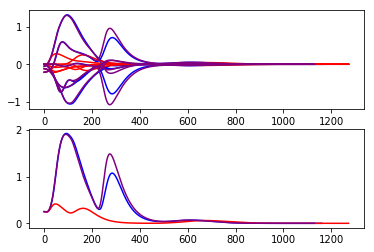

In [89]:

fig, axs = plt.subplots(2, 1)
axs[0].plot(TT_res['traj_e'][:, :6], c='blue')
axs[0].plot(OSG_res['traj_e'][:, :6], c='red')
axs[0].plot(OS_res['traj_e'][:, :6], c='purple')
axs[1].plot(np.linalg.norm(TT_res['traj_e'][:, :6], axis=1), c='blue')
axs[1].plot(np.linalg.norm(OSG_res['traj_e'][:, :6], axis=1), c='red')
axs[1].plot(np.linalg.norm(OS_res['traj_e'][:, :6], axis=1), c='purple')
plt.show()



In [90]:
env.Reset()
env.Load('/home/hung/git/robotic-CRI/rave/denso_vs060.dae')
env.Load('/home/hung/git/robotic-CRI/rave/denso_vs060.dae')
robot2 = env.GetRobots()[1]
robot = env.GetRobots()[0]

In [91]:
# Make robot 2, which will runs the parameterization, shifted a little behind
I = np.eye(4)
I[:3, 3] = [-0.008, -0.008, - 0.008]
robot2.SetTransform(I)

In [92]:
for l in env.GetRobots()[1].GetLinks():
    for geom in l.GetGeometries():
        geom.SetTransparency(0.1)
        geom.SetDiffuseColor([0.9, 0.3, 0.3])

for l in env.GetRobots()[0].GetLinks():
    for geom in l.GetGeometries():
        geom.SetTransparency(0)
#         geom.SetDiffuseColor([0.0, 0.5, 0.5])

## Preview TT controller

In [101]:
slowdown = 5
robot.SetDOFValues(TT_res['traj_q'][0])
robot2.SetDOFValues(qs[0])
time.sleep(5)
for q_, q_2 in zip(TT_res['traj_q'], qs):
    robot.SetDOFValues(q_)
    robot2.SetDOFValues(q_2)
    time.sleep(1e-3 * slowdown)
time.sleep(1)

In [102]:
slowdown = 5
qs_OS = path.eval(OS_res['traj_s'])
robot.SetDOFValues(OS_res['traj_q'][0])
robot2.SetDOFValues(qs_OS[0])
time.sleep(5)
for q_, q_2 in zip(OS_res['traj_q'], qs_OS):
    robot.SetDOFValues(q_)
    robot2.SetDOFValues(q_2)
    time.sleep(1e-3 * slowdown)
time.sleep(1)

In [103]:
slowdown = 5
qs_OSG = path.eval(OSG_res['traj_s'])
robot.SetDOFValues(OSG_res['traj_q'][0])
robot2.SetDOFValues(qs_OSG[0])
time.sleep(5)
for q_, q_2 in zip(OSG_res['traj_q'], qs_OSG):
    robot.SetDOFValues(q_)
    robot2.SetDOFValues(q_2)
    time.sleep(1e-3 * slowdown)
time.sleep(1)

In [99]:
print TT_res['traj_t'][-1], OS_res['traj_t'][-1], OSG_res['traj_t'][-1]

1.161 1.13 1.273


In [100]:
robot.SetDOFValues(TT_res['traj_q'][0])
robot2.SetDOFValues(qs[0])

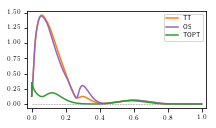

In [104]:
###############################################################################
#                    Compare norm of tracking error                    #
###############################################################################
# PLotting
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.labelsize'] = 'small'
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['text.usetex'] = True
f, ax = plt.subplots(figsize=[3.2, 1.8])
ax.plot(ss_ref,
        np.linalg.norm(TT_res['traj_e'][:, :3], axis=1), '-',
        label='TT', c='C1')
ax.plot(OS_res['traj_s'],
        np.linalg.norm(OS_res['traj_e'][:, :3], axis=1), '-',
        label='OS', c='C4')
ax.plot(OSG_res['traj_s'],
        np.linalg.norm(OSG_res['traj_e'][:, :3], axis=1),
        label='TOPT', c='C2')
ax.plot((0, 1), (0, 0), '--', lw=0.5, c='gray')
# ax.set_ylim(-0.0015, 0.02)
ax.set_xlim(-0.025, 1.025)
# ax.set_yticks(np.arange(0, 0.021, 0.002))
ax.legend()
plt.savefig('/home/hung/git/hung/Papers/2017-TOPP-following/figures/6axis_compare_tracking_performance.pdf')
plt.show()

## Error trajectory

In [59]:
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def update_line(num, data, line):
    line.set_data(data[..., :num])
    return line,

# Fixing random state for reproducibility
np.random.seed(19680801)


# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)


fig1 = plt.figure()

data = np.random.rand(2, 25)
l1, = plt.plot([], [], 'r-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.title('test')
line_ani = animation.FuncAnimation(fig1, update_line, 25, fargs=(data, l),
                                   interval=50, blit=True)
line_ani.save('/home/hung/Videos/lines.mp4', writer=writer)

fig2 = plt.figure()

x = np.arange(-9, 10)
y = np.arange(-9, 10).reshape(-1, 1)
base = np.hypot(x, y)
ims = []
for add in np.arange(15):
    ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))

im_ani = animation.ArtistAnimation(fig2, ims, interval=50, repeat_delay=3000,
                                   blit=True)
im_ani.save('/home/hung/Videos/im.mp4', writer=writer)